# Swing-Up Cart-Pole with PPO (Proximal Policy Optimization)

In [2]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3 import DQN, A2C

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

from collections import defaultdict

Training Call back to tell

Number of timesteps / Episodes

Best Reward / Last Reward per episode / Mean Reward last 10 episode / Delta mean Reward

In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1, reward_function: str = None, file_name: str = None):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "Best Models", reward_function, file_name)
        self.best_reward = -np.inf
        self.prev_mean_reward = 0.0

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "episodes")
          if len(x) > 0:
              # Mean training reward over the last 10 episodes
              last_ep = x[-1]
              last_reward = y[-1] 
              mean_reward = np.mean(y[-10:])
              delta_mearn_reward = mean_reward - self.prev_mean_reward
              self.prev_mean_reward = mean_reward
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps} - Ep: {last_ep}")
                print(f"Best reward: {self.best_reward:.2f} - Last reward per episode: {last_reward:.2f} - Mean reward last 10 episode: {mean_reward:.2f} - Delta mean: {delta_mearn_reward:.2f}")

              # New best model, you could save the agent here
              if last_reward > self.best_reward:
                  self.best_reward = last_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

## Training Phase

In [3]:
def make_env(env_id: str, rank: int, seed: int = 0, render_mode = None, action_type = "Box", observation_type = "Continous", reward_function = "Absolute", task = "InvertedCartPole"):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = gym.make(env_id, render_mode=render_mode, action_type = action_type, observation_type = observation_type, reward_function = reward_function, task = task) #gym.make(env_id, render_mode="human")
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    # log_dir = "tmpa/"
    # os.makedirs(log_dir, exist_ok=True)

    env_id = "CartPole-v1"
    num_cpu = 3  # Number of processes to use
    total_timesteps=500_000 #
    Algorithm_name = 'PPO'
    reward_function = "Sparse"

    log_dir = os.path.join('Training', 'Save Models', Algorithm_name)
    os.makedirs(log_dir, exist_ok=True)

    # Create the vectorized environment
    vec_env = SubprocVecEnv([make_env(env_id, i, reward_function=reward_function) for i in range(num_cpu)])
    vec_env = VecMonitor(vec_env, log_dir)
    # env = gym.make(env_id)
    # print(vec_env)

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, reward_function=reward_function, file_name='{}_ip_{}_{}'.format(Algorithm_name, num_cpu, total_timesteps))


    model = PPO("MlpPolicy", vec_env, verbose=0)
    model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=callback) #250000 callback=callback

Output()

Num timesteps: 3000 - Ep: 7

Best reward: -inf - Last reward per episode: -462.00 - Mean reward last 10 episode: -297.75 - Delta mean: -297.75

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 6000 - Ep: 19

Best reward: -462.00 - Last reward per episode: -80.00 - Mean reward last 10 episode: -238.70 - Delta mean: 59.05

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 9000 - Ep: 36

Best reward: -80.00 - Last reward per episode: -83.00 - Mean reward last 10 episode: -155.90 - Delta mean: 82.80

Num timesteps: 12000 - Ep: 54

Best reward: -80.00 - Last reward per episode: -82.00 - Mean reward last 10 episode: -177.80 - Delta mean: -21.90

Num timesteps: 15000 - Ep: 73

Best reward: -80.00 - Last reward per episode: -123.00 - Mean reward last 10 episode: -124.40 - Delta mean: 53.40

Num timesteps: 18000 - Ep: 98

Best reward: -80.00 - Last reward per episode: -122.00 - Mean reward last 10 episode: -101.70 - Delta mean: 22.70

Num timesteps: 21000 - Ep: 131

Best reward: -80.00 - Last reward per episode: -85.00 - Mean reward last 10 episode: -91.20 - Delta mean: 10.50

Num timesteps: 24000 - Ep: 163

Best reward: -80.00 - Last reward per episode: -95.00 - Mean reward last 10 episode: -88.20 - Delta mean: 3.00

Num timesteps: 27000 - Ep: 204

Best reward: -80.00 - Last reward per episode: -61.00 - Mean reward last 10 episode: -61.50 - Delta mean: 26.70

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 30000 - Ep: 245

Best reward: -61.00 - Last reward per episode: -84.00 - Mean reward last 10 episode: -74.20 - Delta mean: -12.70

Num timesteps: 33000 - Ep: 292

Best reward: -61.00 - Last reward per episode: -50.00 - Mean reward last 10 episode: -59.40 - Delta mean: 14.80

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 36000 - Ep: 344

Best reward: -50.00 - Last reward per episode: -49.00 - Mean reward last 10 episode: -58.70 - Delta mean: 0.70

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 39000 - Ep: 399

Best reward: -49.00 - Last reward per episode: -54.00 - Mean reward last 10 episode: -48.20 - Delta mean: 10.50

Num timesteps: 42000 - Ep: 455

Best reward: -49.00 - Last reward per episode: -52.00 - Mean reward last 10 episode: -48.80 - Delta mean: -0.60

Num timesteps: 45000 - Ep: 516

Best reward: -49.00 - Last reward per episode: -46.00 - Mean reward last 10 episode: -47.60 - Delta mean: 1.20

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 48000 - Ep: 579

Best reward: -46.00 - Last reward per episode: -44.00 - Mean reward last 10 episode: -43.80 - Delta mean: 3.80

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 51000 - Ep: 646

Best reward: -44.00 - Last reward per episode: -45.00 - Mean reward last 10 episode: -42.90 - Delta mean: 0.90

Num timesteps: 54000 - Ep: 714

Best reward: -44.00 - Last reward per episode: -39.00 - Mean reward last 10 episode: -43.30 - Delta mean: -0.40

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 57000 - Ep: 783

Best reward: -39.00 - Last reward per episode: -40.00 - Mean reward last 10 episode: -40.00 - Delta mean: 3.30

Num timesteps: 60000 - Ep: 854

Best reward: -39.00 - Last reward per episode: -37.00 - Mean reward last 10 episode: -40.10 - Delta mean: -0.10

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 63000 - Ep: 928

Best reward: -37.00 - Last reward per episode: -37.00 - Mean reward last 10 episode: -37.80 - Delta mean: 2.30

Num timesteps: 66000 - Ep: 1002

Best reward: -37.00 - Last reward per episode: -38.00 - Mean reward last 10 episode: -38.00 - Delta mean: -0.20

Num timesteps: 69000 - Ep: 1078

Best reward: -37.00 - Last reward per episode: -38.00 - Mean reward last 10 episode: -36.70 - Delta mean: 1.30

Num timesteps: 72000 - Ep: 1154

Best reward: -37.00 - Last reward per episode: -37.00 - Mean reward last 10 episode: -37.10 - Delta mean: -0.40

Num timesteps: 75000 - Ep: 1232

Best reward: -37.00 - Last reward per episode: -38.00 - Mean reward last 10 episode: -34.80 - Delta mean: 2.30

Num timesteps: 78000 - Ep: 1310

Best reward: -37.00 - Last reward per episode: -31.00 - Mean reward last 10 episode: -34.20 - Delta mean: 0.60

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 81000 - Ep: 1388

Best reward: -31.00 - Last reward per episode: -36.00 - Mean reward last 10 episode: -35.70 - Delta mean: -1.50

Num timesteps: 84000 - Ep: 1467

Best reward: -31.00 - Last reward per episode: -30.00 - Mean reward last 10 episode: -33.80 - Delta mean: 1.90

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 87000 - Ep: 1547

Best reward: -30.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -31.50 - Delta mean: 2.30

Saving new best model to Training\Save Models\PPO\Best Models\Sparse\PPO_ip_3_500000

Num timesteps: 90000 - Ep: 1625

Best reward: -27.00 - Last reward per episode: -29.00 - Mean reward last 10 episode: -31.10 - Delta mean: 0.40

Num timesteps: 93000 - Ep: 1706

Best reward: -27.00 - Last reward per episode: -29.00 - Mean reward last 10 episode: -30.30 - Delta mean: 0.80

Num timesteps: 96000 - Ep: 1784

Best reward: -27.00 - Last reward per episode: -28.00 - Mean reward last 10 episode: -30.50 - Delta mean: -0.20

Num timesteps: 99000 - Ep: 1865

Best reward: -27.00 - Last reward per episode: -29.00 - Mean reward last 10 episode: -28.30 - Delta mean: 2.20

Num timesteps: 102000 - Ep: 1946

Best reward: -27.00 - Last reward per episode: -28.00 - Mean reward last 10 episode: -31.80 - Delta mean: -3.50

Num timesteps: 105000 - Ep: 2026

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -28.90 - Delta mean: 2.90

Num timesteps: 108000 - Ep: 2106

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -29.40 - Delta mean: -0.50

Num timesteps: 111000 - Ep: 2187

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.70 - Delta mean: 1.70

Num timesteps: 114000 - Ep: 2268

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.60 - Delta mean: 0.10

Num timesteps: 117000 - Ep: 2349

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.60 - Delta mean: 0.00

Num timesteps: 120000 - Ep: 2430

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: 0.40

Num timesteps: 123000 - Ep: 2511

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.80 - Delta mean: -0.60

Num timesteps: 126000 - Ep: 2592

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -28.20 - Delta mean: -0.40

Num timesteps: 129000 - Ep: 2673

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.80 - Delta mean: 0.40

Num timesteps: 132000 - Ep: 2754

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: 0.40

Num timesteps: 135000 - Ep: 2835

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.60 - Delta mean: -0.20

Num timesteps: 138000 - Ep: 2917

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.60 - Delta mean: 0.00

Num timesteps: 141000 - Ep: 2998

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: 0.20

Num timesteps: 144000 - Ep: 3079

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: 0.20

Num timesteps: 147000 - Ep: 3160

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: -0.20

Num timesteps: 150000 - Ep: 3241

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.40

Num timesteps: 153000 - Ep: 3322

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 156000 - Ep: 3403

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 159000 - Ep: 3485

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: -0.40

Num timesteps: 162000 - Ep: 3566

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: 0.00

Num timesteps: 165000 - Ep: 3647

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.40

Num timesteps: 168000 - Ep: 3728

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.40 - Delta mean: -0.40

Num timesteps: 171000 - Ep: 3809

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: 0.20

Num timesteps: 174000 - Ep: 3890

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 177000 - Ep: 3971

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 180000 - Ep: 4052

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 183000 - Ep: 4133

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 186000 - Ep: 4214

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 189000 - Ep: 4295

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 192000 - Ep: 4376

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 195000 - Ep: 4457

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 198000 - Ep: 4538

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 201000 - Ep: 4619

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 204000 - Ep: 4700

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 207000 - Ep: 4781

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 210000 - Ep: 4863

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 213000 - Ep: 4944

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 216000 - Ep: 5025

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 219000 - Ep: 5106

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 222000 - Ep: 5187

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 225000 - Ep: 5268

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 228000 - Ep: 5349

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 231000 - Ep: 5430

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 234000 - Ep: 5511

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 237000 - Ep: 5592

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 240000 - Ep: 5673

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 243000 - Ep: 5754

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 246000 - Ep: 5835

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 249000 - Ep: 5917

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 252000 - Ep: 5998

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 255000 - Ep: 6079

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: 0.00

Num timesteps: 258000 - Ep: 6160

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 261000 - Ep: 6241

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 264000 - Ep: 6322

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 267000 - Ep: 6403

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 270000 - Ep: 6485

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 273000 - Ep: 6566

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 276000 - Ep: 6647

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 279000 - Ep: 6728

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 282000 - Ep: 6809

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 285000 - Ep: 6890

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 288000 - Ep: 6971

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 291000 - Ep: 7052

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 294000 - Ep: 7133

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 297000 - Ep: 7214

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 300000 - Ep: 7295

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 303000 - Ep: 7376

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 306000 - Ep: 7457

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 309000 - Ep: 7538

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.20 - Delta mean: -0.20

Num timesteps: 312000 - Ep: 7619

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.20

Num timesteps: 315000 - Ep: 7700

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 318000 - Ep: 7781

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 321000 - Ep: 7863

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 324000 - Ep: 7944

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 327000 - Ep: 8025

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 330000 - Ep: 8106

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 333000 - Ep: 8187

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 336000 - Ep: 8268

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 339000 - Ep: 8349

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 342000 - Ep: 8430

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 345000 - Ep: 8511

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 348000 - Ep: 8592

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 351000 - Ep: 8673

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 354000 - Ep: 8754

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 357000 - Ep: 8835

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 360000 - Ep: 8917

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 363000 - Ep: 8998

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 366000 - Ep: 9079

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 369000 - Ep: 9160

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 372000 - Ep: 9241

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 375000 - Ep: 9322

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 378000 - Ep: 9403

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 381000 - Ep: 9485

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 384000 - Ep: 9566

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 387000 - Ep: 9647

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 390000 - Ep: 9728

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 393000 - Ep: 9809

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 396000 - Ep: 9890

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 399000 - Ep: 9971

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 402000 - Ep: 10052

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 405000 - Ep: 10133

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 408000 - Ep: 10214

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 411000 - Ep: 10295

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 414000 - Ep: 10376

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 417000 - Ep: 10457

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 420000 - Ep: 10538

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 423000 - Ep: 10619

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 426000 - Ep: 10700

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 429000 - Ep: 10781

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 432000 - Ep: 10863

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 435000 - Ep: 10944

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 438000 - Ep: 11025

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 441000 - Ep: 11106

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 444000 - Ep: 11187

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 447000 - Ep: 11268

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 450000 - Ep: 11349

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 453000 - Ep: 11430

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 456000 - Ep: 11511

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 459000 - Ep: 11592

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 462000 - Ep: 11673

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 465000 - Ep: 11754

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 468000 - Ep: 11835

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 471000 - Ep: 11917

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 474000 - Ep: 11998

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 477000 - Ep: 12079

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 480000 - Ep: 12160

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 483000 - Ep: 12241

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 486000 - Ep: 12322

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 489000 - Ep: 12403

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 492000 - Ep: 12485

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 495000 - Ep: 12566

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 498000 - Ep: 12647

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

Num timesteps: 501000 - Ep: 12728

Best reward: -27.00 - Last reward per episode: -27.00 - Mean reward last 10 episode: -27.00 - Delta mean: 0.00

### Graph: Display Episode Rewards for PPO algorithm / Reward Function

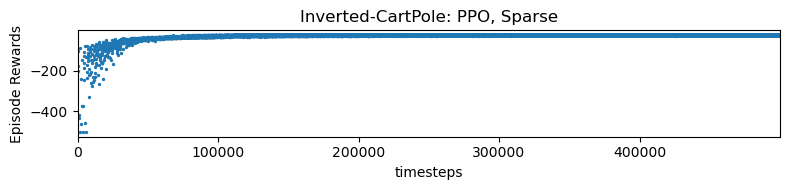

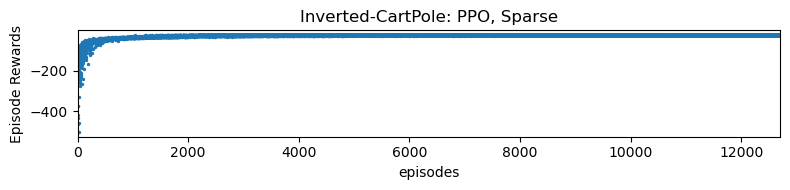

In [4]:
plot_results([log_dir], total_timesteps, results_plotter.X_TIMESTEPS, "Inverted-CartPole: {}, {}".format(Algorithm_name, reward_function))
plt.show()
plot_results([log_dir], total_timesteps, results_plotter.X_EPISODES, "Inverted-CartPole: {}, {}".format(Algorithm_name, reward_function))
plt.show()

Save model

In [5]:
# the saved model does not contain the replay buffer
PPO_Path = os.path.join('Training', 'Save Models','PPO', 'Best Models', 'Absolute', 'PPO_ip_3_400000.zip')
loaded_model = PPO.load(PPO_Path)
print(f"The loaded_model has {loaded_model} transitions in its buffer")

The loaded_model has <stable_baselines3.ppo.ppo.PPO object at 0x00000277DA8D9A30> transitions in its buffer


## Testing Phase

In [ ]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode="human", action_type = "Box", observation_type = "Continous", reward_function = "Absolute", task = "InvertedCartPole")
obs_ls = []
episodes = 100

pole_pos_np_min = defaultdict(lambda: 0)
pole_pos_np_max = defaultdict(lambda: 0)
avg_error_pole_pos_dict = defaultdict(lambda: 0)

cart_pos_np_min = defaultdict(lambda: 0)
cart_pos_np_max = defaultdict(lambda: 0)
avg_error_cart_pos_dict = defaultdict(lambda: 0)

pole_vel_np_min = defaultdict(lambda: 0)
pole_vel_np_max = defaultdict(lambda: 0)
avg_error_pole_vel_dict = defaultdict(lambda: 0)

cart_vel_np_min = defaultdict(lambda: 0)
cart_vel_np_max = defaultdict(lambda: 0)
avg_error_cart_vel_dict = defaultdict(lambda: 0)

N_pos_dict = defaultdict(lambda: 0)
N_vel_dict = defaultdict(lambda: 0)

for episodes in range(1, episodes+1):
    obs, _ = env.reset()
    done = False
    score = 0
    time_step = 0

    while not done:
        env.render()
        action = loaded_model.predict(obs)
        obs, reward, done, truncated, info = env.step(action[0])
        score += reward
        obs_ls.append(obs[2])

        time_step += 1

        cart_pos = obs[0]
        cart_vel = obs[1]
        pole_pos = obs[2]
        pole_vel = obs[3]

        if cart_pos >= cart_pos_np_max[time_step - 1]:
            cart_pos_np_max[time_step - 1] = cart_pos
        if cart_pos <= cart_pos_np_min[time_step - 1]:
            cart_pos_np_min[time_step - 1] = cart_pos

        if pole_pos >= pole_pos_np_max[time_step - 1]:
            pole_pos_np_max[time_step - 1] = pole_pos
        if pole_pos <= pole_pos_np_min[time_step - 1]:
            pole_pos_np_min[time_step - 1] = pole_pos

        N_pos_dict[time_step - 1] += 1
        avg_error_cart_pos_dict[time_step - 1] = avg_error_cart_pos_dict[time_step - 1] + (cart_pos - avg_error_cart_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]
        avg_error_pole_pos_dict[time_step - 1] = avg_error_pole_pos_dict[time_step - 1] + (pole_pos - avg_error_pole_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]

        if cart_vel >= cart_vel_np_max[time_step - 1]:
            cart_vel_np_max[time_step - 1] = cart_vel
        if cart_vel <= cart_vel_np_min[time_step - 1]:
            cart_vel_np_min[time_step - 1] = cart_vel

        if pole_vel >= pole_vel_np_max[time_step - 1]:
            pole_vel_np_max[time_step - 1] = pole_vel
        if pole_vel <= pole_vel_np_min[time_step - 1]:
            pole_vel_np_min[time_step - 1] = pole_vel

        N_vel_dict[time_step - 1] += 1
        avg_error_cart_vel_dict[time_step - 1] = avg_error_cart_vel_dict[time_step - 1] + (cart_vel - avg_error_cart_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]
        avg_error_pole_vel_dict[time_step - 1] = avg_error_pole_vel_dict[time_step - 1] + (pole_vel - avg_error_pole_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]
        
    # print('Episode:{} Score:{}'.format(episodes, score))
env.close()

### Graph: Avg.Pole Position and Velocity vs Time steps [Testing] 

stabilized_index_pos:  116
Minimum value in stabilized region: -0.0514992
Maximum value in stabilized region: 0.04487639


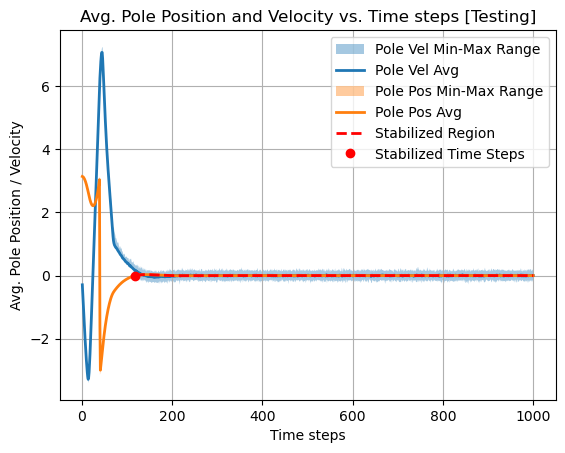

In [27]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(pole_pos_np_min)):
    if pole_pos_np_min[i] == 0:
        pole_pos_np_min[i] = avg_error_pole_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        pole_pos_np_max[i] = avg_error_pole_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(pole_vel_np_min)):
    if pole_vel_np_min[i] == 0:
        pole_vel_np_min[i] = avg_error_pole_vel_dict[i]
    if pole_vel_np_max[i] == 0:
        pole_vel_np_max[i] = avg_error_pole_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array for array in pole_vel_np_min.values()]
y_vel_max = [array for array in pole_vel_np_max.values()]
y_vel_avg = [array for array in avg_error_pole_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Pole Vel Min-Max Range')

# Plot average error for pole velocity
ax.plot(x, y_vel_avg, linewidth=2, label='Pole Vel Avg')

y_pos_min = [array for array in pole_pos_np_min.values()]
y_pos_max = [array for array in pole_pos_np_max.values()]
y_pos_avg = [array for array in avg_error_pole_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Pole Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Pole Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.008)[0]
print("stabilized_index_pos: ", stabilized_index_pos[0])

# Plot dashed line for stabilized region and change its color to red
if len(stabilized_index_pos) > 0:
    start_stable = stabilized_index_pos[0]
    end_stable = stabilized_index_pos[-1]
    stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
    stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
    print("Minimum value in stabilized region:", stabilized_y_min)
    print("Maximum value in stabilized region:", stabilized_y_max)

    start_stable = stabilized_index_pos[0]
    end_stable = stabilized_index_pos[-1]
    ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

    # Plot markers for stabilized time steps
    ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Pole Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Pole Position / Velocity')

# Add legend
ax.legend()

plt.show()

### Graph: Avg.Cart Position and Velocity vs Time steps [Testing] 

stabilized_index_cart:  116
Minimum value in stabilized region: -0.16163129
Maximum value in stabilized region: 0.32954288


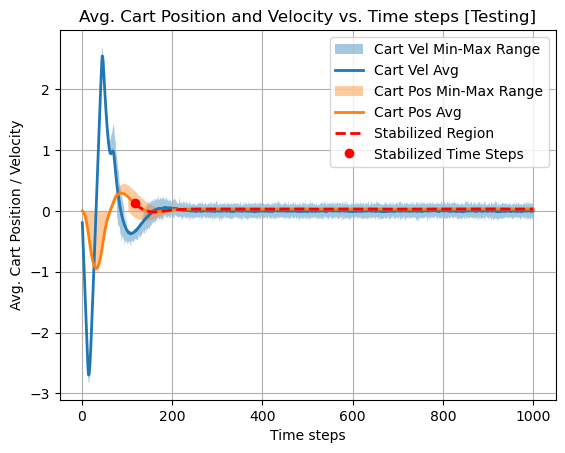

In [28]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(cart_pos_np_min)):
    if cart_pos_np_min[i] == 0:
        cart_pos_np_min[i] = avg_error_cart_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        cart_pos_np_max[i] = avg_error_cart_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(cart_vel_np_min)):
    if cart_vel_np_min[i] == 0:
        cart_vel_np_min[i] = avg_error_cart_vel_dict[i]
    if cart_vel_np_max[i] == 0:
        cart_vel_np_max[i] = avg_error_cart_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array for array in cart_vel_np_min.values()]
y_vel_max = [array for array in cart_vel_np_max.values()]
y_vel_avg = [array for array in avg_error_cart_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Cart Vel Min-Max Range')

# Plot average error for pole velocity
ax.plot(x, y_vel_avg, linewidth=2, label='Cart Vel Avg')

y_pos_min = [array for array in cart_pos_np_min.values()]
y_pos_max = [array for array in cart_pos_np_max.values()]
y_pos_avg = [array for array in avg_error_cart_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Cart Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Cart Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.008)[0]
print("stabilized_index_cart: ", start_stable)

# Plot dashed line for stabilized region and change its color to red
if len(stabilized_index_pos) > 0:
    # start_stable = stabilized_index_pos[0]
    # end_stable = stabilized_index_pos[-1]
    stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
    stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
    print("Minimum value in stabilized region:", stabilized_y_min)
    print("Maximum value in stabilized region:", stabilized_y_max)

    ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

    # Plot markers for stabilized time steps
    ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Cart Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Cart Position / Velocity')

# Add legend
ax.legend()

plt.show()